# Using Qiskit Terra


Qiskit Terra contains tools that **define**, **compile** and **execute** quantum circuits on arbitrary **backends**.
It allows users to manipulate qubits by using gates and even construct circuits at the level of **pulses**

## *Transpiling a quantum circuit*

In [18]:
# Import required fuctions from qiskit
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, IBMQ, Aer
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.backends.ibmq_athens


ibmqfactory.load_account:WARNING:2021-03-01 18:20:43,817: Credentials are already in use. The existing account in the session will be replaced.


# What goes on under the hood when you call `execute`

### Execute calls Assemble to convert the circuit into a Qobj, which is a backend-specific object. 
### While doing so, execute also calls 

   - The transpiler, which converts the circuit into a Directed Acyclic Graph(DAG) of gates,
   - and optimizes the DAG for the target execution backend (DAGs are much easier to optimize than circuits).

### Directed Acyclic Graph (DAG)  are created using  qiskit.compiler.transpile()
### Qobjs are created  using    qiskit.compiler.assemble() 

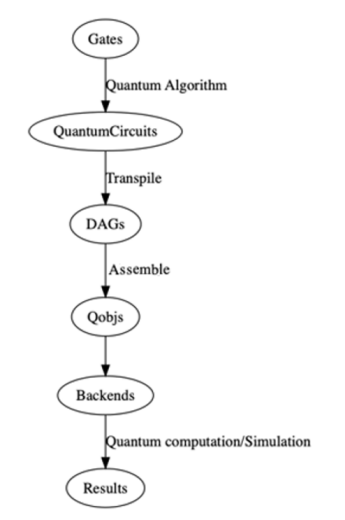

In [19]:
# let's consider this circuit
ghz = QuantumCircuit(3,3)
ghz.h(0)
ghz.cx(0,1)
ghz.cx(0,2)
ghz.measure([0,1,2], [0,1,2])
ghz.draw()

┌───┐             ┌─┐   
q_0: ┤ H ├──■────■─────┤M├───
     └───┘┌─┴─┐  │  ┌─┐└╥┘   
q_1: ─────┤ X ├──┼──┤M├─╫────
          └───┘┌─┴─┐└╥┘ ║ ┌─┐
q_2: ──────────┤ X ├─╫──╫─┤M├
               └───┘ ║  ║ └╥┘
c: 3/════════════════╩══╩══╩═
                     1  0  2

In [20]:
# let's create a "qobj" and run it on the simulator without tranpiling it
from qiskit.compiler import assemble
qobj_ghz = assemble(ghz)
print(qobj_ghz)

QASM Qobj: 7cf9bd93-1a4c-4c5f-af85-d08c08b8bad2:
Config: {'init_qubits': True,
 'memory': False,
 'memory_slots': 3,
 'n_qubits': 3,
 'parameter_binds': [],
 'shots': 1024}
Header: {}
Experiments:

QASM Experiment:
Header:
{'clbit_labels': [['c', 0], ['c', 1], ['c', 2]],
 'creg_sizes': [['c', 3]],
 'global_phase': 0.0,
 'memory_slots': 3,
 'n_qubits': 3,
 'name': 'circuit10',
 'qreg_sizes': [['q', 3]],
 'qubit_labels': [['q', 0], ['q', 1], ['q', 2]]}
Config:
{'memory_slots': 3, 'n_qubits': 3}

	Instruction: h
		qubits: [0]

	Instruction: cx
		qubits: [0, 1]

	Instruction: cx
		qubits: [0, 2]

	Instruction: measure
		qubits: [0]
		memory: [0]

	Instruction: measure
		qubits: [1]
		memory: [1]

	Instruction: measure
		qubits: [2]
		memory: [2]




In [21]:
job_sim = Aer.get_backend('qasm_simulator').run(qobj_ghz)

print(job_sim.status())
print(job_sim.result().get_counts())
print(job_sim.status())

JobStatus.INITIALIZING
{'000': 540, '111': 484}
JobStatus.DONE


In [22]:
# let's run it on a real backend 'ibmq_athens'
backend = provider.get_backend('ibmq_athens')
job_real = backend.run(qobj_ghz)
print(job_real.status())



JobStatus.VALIDATING


In [23]:
print(job_real.status())
print(job_real.result())

JobStatus.ERROR


IBMQJobFailureError: "Unable to retrieve result for job 603d2282badec242adaed0f5. Job has failed: The Qobj uses gates (['h']) that are not among the basis gates (['id', 'rz', 'sx', 'x', 'cx', 'reset']). Error code: 1106."

In [24]:
# we retrieve the error message 
print(job_real.error_message())

The Qobj uses gates (['h']) that are not among the basis gates (['id', 'rz', 'sx', 'x', 'cx', 'reset']). Error code: 1106.


### We can notice that we 'h' gate is not understood. The standard gates must be expanded in terms of gates supported by the decice.  
#### let's see what are the basis gates supported by the backend device 'ibmq_athens' 

In [25]:
backend.configuration().basis_gates

['id', 'rz', 'sx', 'x', 'cx', 'reset']

We see that the device 'ibmq_athens' supports six native gates: four single-qubit gates (id, sx, x, rz) and one two-qubit entangling gate cx. Note that reset is not a Gate operation, since it is irreversible. Although we have queried only a single device, all IBM Q devices support this gate set.

The tranpiling process "Unroll" the circuit to a given basis (it uses the Unroller pass) 

### So what about removing the Hadamard gate from the circuit

In [26]:
ghz = QuantumCircuit(3,3)
#ghz.h(0)
ghz.cx(0,1)
ghz.cx(0,2)
ghz.measure([0,1,2], [0,1,2])
ghz.draw()

┌─┐   
q_0: ──■────■─────┤M├───
     ┌─┴─┐  │  ┌─┐└╥┘   
q_1: ┤ X ├──┼──┤M├─╫────
     └───┘┌─┴─┐└╥┘ ║ ┌─┐
q_2: ─────┤ X ├─╫──╫─┤M├
          └───┘ ║  ║ └╥┘
c: 3/═══════════╩══╩══╩═
                1  0  2

In [27]:
qobj_ghz = assemble(ghz)
job_real = backend.run(qobj_ghz)
print(job_real.status())
print(job_real.result())

JobStatus.VALIDATING


IBMQJobFailureError: 'Unable to retrieve result for job 603d23b07a77b12e593e87d5. Job has failed: The Qobj includes an instruction that assumes a coupling map different than the specified coupling map. Error code: 1107.'

In [28]:
# we retrieve the error message.
# We have a new error message
print(job_real.error_message())

The Qobj includes an instruction that assumes a coupling map different than the specified coupling map. Error code: 1107.


## *Let's look at athens' coupling map*
 

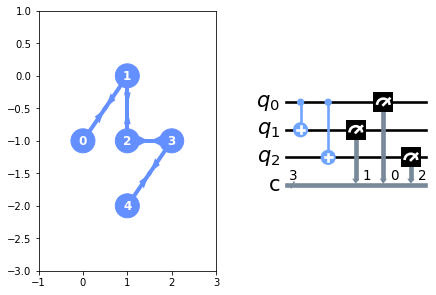

In [16]:
from qiskit.visualization import plot_gate_map
backend = provider.get_backend('ibmq_athens')

# plot the coupling map for athens and draw the circuits 
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=2)
ghz.draw(output='mpl',scale=1.3, ax=ax[1])
plot_gate_map(backend, plot_directed=True, ax=ax[0])


###  The topology is encoded in what qiskit calls the coupling_map, and the coupling map for a device can be obtained from its configuration

In [29]:
backend = provider.get_backend('ibmq_athens')
backend.configuration().coupling_map

[[0, 1], [1, 0], [1, 2], [2, 1], [2, 3], [3, 2], [3, 4], [4, 3]]

### We can notice that we don't have a connection between qubit 0 and qubit 2, that's the reason of the error 
#### The goal of the transpilation is to 
- Transform a given quantum circuit into one which is executable on a specifc device, preserving measurement outcomes (compatibility)
- Find an implementation which takes maximal advantage of device resources, while minimizing infuence of decoherence and errors.(Optimization)


## *Now it's your turn to play!* - *First challenge*
<div class="alert alert-block alert-info">
<b>Note:</b>
Here's a first challenge for you: Transpile the circuit to "Unroll" to a given basis
    
   - Transpile the circuit to unroll non-basis gates to desired basis 'u3' and 'cx' gates. 
   - Then draw the transpiled circuit and count the operations (gates)
</div>

In [ ]:
# Consider the circuit below
qr = QuantumRegister(5, 'q')
tpl_circuit = QuantumCircuit(qr)
tpl_circuit.h(qr[3])
tpl_circuit.ccx(qr[0], qr[1], qr[4])
tpl_circuit.cx(qr[4], qr[0])
tpl_circuit.cx(qr[0], qr[1])
tpl_circuit.cx(qr[3], qr[1])
tpl_circuit.cx(qr[3], qr[0])
tpl_circuit.draw()

In [ ]:
# transpile the circuit and specify the basis gates to unroll to 



In [ ]:
# Draw the circuit when transpiled 



In [ ]:
# counts the operation in the circuit



## *Now it's your turn to play!* - *Second challenge*
<div class="alert alert-block alert-info">
<b>Note:</b>
Here's a second challenge for you: Consider the ciruit ghz2_circ below. 
 
  - First: Tranpile the circuit using "ibmq_16_melbourne" backend, and print out the count operations and depth of the transpiled circuit
  - Second: Optimize the transpilation using a specific "initial_layout" to get the best circuit depth 
    
<b>Note:</b> An initial_layout is an initial position of virtual qubits on physical qubits.
            If this layout makes the circuit compatible with the coupling_map constraints, it will be used.
            The final layout is not guaranteed to be the same, as the transpiler may permute qubits through swaps or other means.
</div> 
</div>

In [ ]:
# Consider the circuit "ghz2_circ" below
ghz2_circ = QuantumCircuit(5, 5)
ghz2_circ.h(2)
ghz2_circ.cx(2, 1)
ghz2_circ.cx(1, 0)
ghz2_circ.cx(1, 3)
ghz2_circ.cx(3, 4)
ghz2_circ.barrier(range(5))
ghz2_circ.measure(range(5), range(5))
ghz2_circ.draw(output='mpl')

#### *First Transpile the circuit using ibmq_16_melbourne as backend*

In [ ]:
# First set your backend as "ibmq_16_melbourne" 



In [ ]:
# transpile your circuit using that backend



In [ ]:
# print the depth and the operation counts for that circuit



In [ ]:
# draw the circuit 



#### *Second: Use an intial layout during transilation that best matches with the circuit*

In [ ]:
# draw the coupling map of the backend "ibmq_16_melbourne"



In [ ]:
# check for a good layout by looking at to which qubits the CNOT gates are applied in the circuit



In [ ]:
# transpile using an initial_layout 



In [ ]:
print count operatins, depth of the circuit,  and draw it



# Challenges solutions 
<div class="alert alert-success">
<b>First Challenge solution</b>

In [ ]:
# Consider the circuit below
qr = QuantumRegister(5, 'q')
tpl_circuit = QuantumCircuit(qr)
tpl_circuit.h(qr[3])
tpl_circuit.ccx(qr[0], qr[1], qr[4])
tpl_circuit.cx(qr[4], qr[0])
tpl_circuit.cx(qr[0], qr[1])
tpl_circuit.cx(qr[3], qr[1])
tpl_circuit.cx(qr[3], qr[0])
tpl_circuit.draw()

In [ ]:
# Specify the basis gates to unroll to 
from qiskit.compiler import transpile
trans = transpile(tpl_circuit, backend, basis_gates=['u3', 'cx'])

In [ ]:
# draw the circuit transpiled 
trans.draw(output='mpl')

In [ ]:
# print the count operations to get the number of gates in the circuit 
print (trans.count_ops())

<div class="alert alert-success">
<b>Second Challenge solution</b>

In [ ]:
# Set the backen to "ibmq_16_melbourne"
backend = provider.backends.ibmq_16_melbourne


# Transpile the circuit 
trans = transpile(ghz2_circ, backend)

# Print out the count of operations 
print(trans.count_ops())

# Print the depth of the circuit
print('Depth:', ghz2_circ.depth())

# Draw the circuit when transpiled
trans.draw(output='mpl', idle_wires=False)


##### *Second: Use an intial layout during transilation that best matches with the circuit* 

In [ ]:
# Check the coupling map of ibmq_16_melbourne 
# Our GHZ circuit consists of a qubit(0) coupled to qubit(1), qubit(1) coupled to qubit(2), qubit(3) coupled to qubit(4).
# We can notice however that qubit(1) is also coupled to qubit(3).
# Look at the gate map for ibmq_16_melbourne to find the best mapping

plot_gate_map(backend, plot_directed=True)

In [ ]:
# looking at the cnot gates in the circuit, 
# we have a cnot for qubits0 and qubit1
# cnot qubit1 and qubit2
# cnot qubit3 and qubit4
# cnot qubit1 and qubit3 
# qubit1 must be connected to qubit2 and qubit3 as a good layout 

# One good layout here below
trans = transpile(ghz2_circ, backend, initial_layout=[14,13,1,12,2])

print(trans.count_ops())
print('Depth:', trans.depth())
trans.draw(output='mpl')